In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output


## Custom functions

In [61]:
def extract_answer(text):
    pattern = r"(True|False|Don't know)"
    matches = re.findall(pattern, text)
    return matches

def process_df(rag_response_df):
    rag_response_df.loc[:, "answer_count"] = rag_response_df.extracted_answer.apply(lambda x:len(x))
    rag_response_df_multiple_answers = rag_response_df[rag_response_df.answer_count > 1]
    rag_response_df_single_answer = rag_response_df.drop(rag_response_df_multiple_answers.index)
    rag_response_df_single_answer.drop("answer_count", axis=1, inplace=True)
    rag_response_df_multiple_answers_ = []
    for index, row in rag_response_df_multiple_answers.iterrows():
        if row["extracted_answer"][0] == row["extracted_answer"][1]:
            rag_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], row["extracted_answer"][0]))
        else:
            rag_response_df_multiple_answers_.append((row["question"], row["label"], row["llm_answer"], None))
    rag_response_df_multiple_answers_ = pd.DataFrame(rag_response_df_multiple_answers_, columns=["question", "label", "llm_answer", "extracted_answer"])
    rag_response_df_final = pd.concat([rag_response_df_single_answer, rag_response_df_multiple_answers_], ignore_index=True)
    rag_response_df_final = rag_response_df_final.explode("extracted_answer")
    
    rag_incorrect_answers_because_of_na = rag_response_df_final[rag_response_df_final.extracted_answer.isna()]

    row_index_to_drop = list(rag_incorrect_answers_because_of_na.index.values)

    rag_response_df_final.drop(row_index_to_drop, inplace=True)

    rag_response_df_final = rag_response_df_final.reset_index()
    response_transform = {
        "True" : True,
        "False" : False
    }

    rag_response_df_final.extracted_answer = rag_response_df_final.extracted_answer.apply(lambda x:response_transform[x])

    return rag_response_df_final


def evaluate(df):
    correct = df[df.label == df.extracted_answer]
    incorrect = df[df.label != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac

def evaluate_2(df):
    correct = df[df.cypher_rag_final_answer == df.label]
    incorrect = df[df.cypher_rag_final_answer != df.label]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac


def bootstrap(cypher_rag, kg_rag, niter = 1000, nsample = 150):
    cypher_rag_correct_frac_list = []
    kg_rag_correct_frac_list = []
    for i in tqdm(range(niter)):
        cypher_rag_ = cypher_rag.sample(n=nsample, random_state=i)
        cypher_rag_correct_frac, cypher_rag_incorrect_frac = evaluate_2(cypher_rag_)
        kg_rag_ = kg_rag.iloc[cypher_rag_.index]
        kg_rag_correct_frac, kg_rag_incorrect_frac = evaluate(kg_rag_)
        cypher_rag_correct_frac_list.append(cypher_rag_correct_frac)
        kg_rag_correct_frac_list.append(kg_rag_correct_frac)
    return cypher_rag_correct_frac_list, kg_rag_correct_frac_list

def plot_figure(cypher_rag_correct_frac_list, kg_rag_correct_frac_list):
    fig = plt.figure(figsize=(5, 3))
    ax = plt.gca()

    sns.kdeplot(cypher_rag_correct_frac_list, color="blue", shade=True, label="Cypher-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)
    sns.kdeplot(kg_rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)

    for artist in ax.lines:
        artist.set_edgecolor("black")

    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    plt.legend(loc="upper left")
    plt.xlim(0,1)

    ax.axvline(np.mean(cypher_rag_correct_frac_list), color='black', linestyle='--', lw=2)
    ax.axvline(np.mean(kg_rag_correct_frac_list), color='black', linestyle='--', lw=2)

    sns.despine(top=True, right=True)
    plt.legend(bbox_to_anchor=(0.3, 0.9))

    plt.show()
    return fig



## Load data and process it

In [62]:
cypher_rag = pd.read_csv('../data/results/cypher_rag_true_false_output.csv')
kg_rag = pd.read_csv('../data/results/gpt_4_PubMedBert_and_entity_recognition_based_node_retrieval_rag_based_true_false_binary_response.csv')
curated_data = pd.read_csv('../data/benchmark_data/true_false_questions.csv').drop('Unnamed: 0', axis=1)

kg_rag = pd.merge(curated_data, kg_rag, left_on='text', right_on='question').drop(['text', 'label_y'], axis=1).rename(columns={'label_x':'label'})
kg_rag.loc[:, 'extracted_answer'] = kg_rag['llm_answer'].apply(extract_answer)
kg_rag = process_df(kg_rag)


## Bootstrap

In [63]:
cypher_rag_correct_frac_list, kg_rag_correct_frac_list = bootstrap(cypher_rag, kg_rag)


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 894.39it/s]


## Plot the figure

/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_39048/2066733470.py:69: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cypher_rag_correct_frac_list, color="blue", shade=True, label="Cypher-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_39048/2066733470.py:70: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kg_rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG", ax=ax, lw=2, linestyle="-", alpha=0.6)


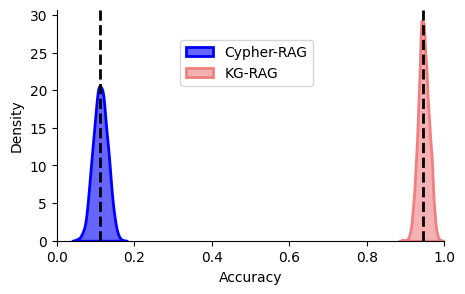

---Cypher-RAG based mean and std---
0.11178666666666666
0.018260066934281605

---KG-RAG based mean and std---
0.9459866666666666
0.013465339868632277


In [68]:
cypher_rag_vs_kg_rag_fig = plot_figure(cypher_rag_correct_frac_list, kg_rag_correct_frac_list)

fig_path = '../data/results/figures'
os.makedirs(fig_path, exist_ok=True)
cypher_rag_vs_kg_rag_fig.savefig(os.path.join(fig_path, 'cypher_rag_vs_kg_rag_true_false.svg'), format='svg', bbox_inches='tight')      

print('---Cypher-RAG based mean and std---')
print(np.mean(cypher_rag_correct_frac_list))
print(np.std(cypher_rag_correct_frac_list))
print('')
print('---KG-RAG based mean and std---')
print(np.mean(kg_rag_correct_frac_list))
print(np.std(kg_rag_correct_frac_list))


## Missed questions by Cypher-rag

In [75]:
missed_question_percentage = 100*cypher_rag[cypher_rag.cypher_rag_final_answer.isna()].shape[0]/cypher_rag.shape[0]
print(f"Cypher-RAG missed {missed_question_percentage}% of questions")


Cypher-RAG missed 72.02572347266882% of questions


In [79]:
cypher_rag[cypher_rag.cypher_rag_final_answer.isna()]

,text,label,cypher_rag_answer,cypher_rag_final_answer,total_tokens
0,enhanced S-cone syndrome is not a vitreoretina...,False,NaN,NaN,3817
1,metronidazole treats crohn's disease,True,"I'm sorry, but I don't have the information to...",NaN,4049
2,KLEEFSTRA SYNDROME 1 is not associated with Ge...,False,NaN,NaN,3861
3,Juvenile polyposis syndrome associates Gene SMAD4,True,"I'm sorry, but I don't have the information to...",NaN,4054
4,Disease ontology identifier for congenital gen...,False,NaN,NaN,3856
...,...,...,...,...,...
304,Noonan Syndrome associates Gene SOS1,True,"I'm sorry, but I don't have the information to...",NaN,4044
306,Congenital amegakaryocytic thrombocytopenia is...,False,"I'm sorry, but I don't have the information to...",NaN,4090
307,Leigh Disease associates Gene NDUFS4,True,NaN,NaN,3908
308,Sandhoff Disease is not associated with Gene HEXB,False,"I'm sorry, but I don't have the information to...",NaN,4064


In [85]:
cypher_rag[cypher_rag.cypher_rag_final_answer.isna()].iloc[219].cypher_rag_answer

"I'm sorry, but I don't have the information to answer that question."

In [80]:
kg_rag.iloc[304]

index                                                304
label                                               True
question            Noonan Syndrome associates Gene SOS1
llm_answer                      {\n  "answer": "True"\n}
extracted_answer                                    True
Name: 304, dtype: object